In [5]:
import pandas as pd

stock_dir = "../225_data"
stock_id = 1333
csv = stock_dir + "/" + str(stock_id) + ".csv"
df = pd.read_csv(
    csv,
    encoding="SHIFT-JIS",
    parse_dates=["日付"],
    na_values=["-"],
    dtype="float",
)
df

,日付,始値,高値,安値,終値,出来高,調整後終値
0,2021-07-02,2380.0,2403.0,2376.0,2395.0,145300.0,2395.0
1,2021-07-01,2373.0,2379.0,2358.0,2366.0,104100.0,2366.0
2,2021-06-30,2404.0,2411.0,2360.0,2361.0,222900.0,2361.0
3,2021-06-29,2418.0,2418.0,2401.0,2404.0,110200.0,2404.0
4,2021-06-28,2432.0,2439.0,2416.0,2432.0,112000.0,2432.0
...,...,...,...,...,...,...,...
1768,2014-04-07,1703.0,1710.0,1687.0,1687.0,150400.0,1687.0
1769,2014-04-04,1716.0,1722.0,1709.0,1716.0,132900.0,1716.0
1770,2014-04-03,1727.0,1735.0,1715.0,1723.0,471300.0,1723.0
1771,2014-04-02,1711.0,1746.0,1711.0,1727.0,672700.0,1727.0


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8)) # グラフのサイズ変更

fig, ax = plt.subplots(1, 2, figsize=(10, 3))  # 2行1列で並べる
df.plot(ax=ax[0])
df.plot(ax=ax[1])

fig, ax = plt.subplots(3, 4, figsize=(10, 3))  # 2行2列で並べる
df.plot(ax=ax[0, 0])
df.plot(ax=ax[1, 0])
df.plot(ax=ax[0, 1])
df.plot(ax=ax[1, 1])

fig, ax = plt.subplots(1, 3, figsize=(20, 5))  # 2行1列で並べる
ax[0].plot(range(0, n, 1), scores_mean, marker='+'); ax[0].set_title('scores_mean'); ax[0].set_xlabel('W')
ax[1].plot(range(0, n, 1), scores_sum, marker='+'); ax[1].set_title('scores_sum'); ax[1].set_xlabel('W')
ax[2].plot(range(0, n, 1), n_rows, marker = '+'); ax[2].set_title('n_rows'); ax[2].set_xlabel('W')

plt.tight_layout(rect=[0,0,1,0.96])  # タイトル重ならないようにする
plt.savefig("result.png", bbox_inches='tight', pad_inches=0)  # bbox_inchesなどは余白削除オプション

plt.show()
plt.clf()  # メモリ解放
plt.close()

1


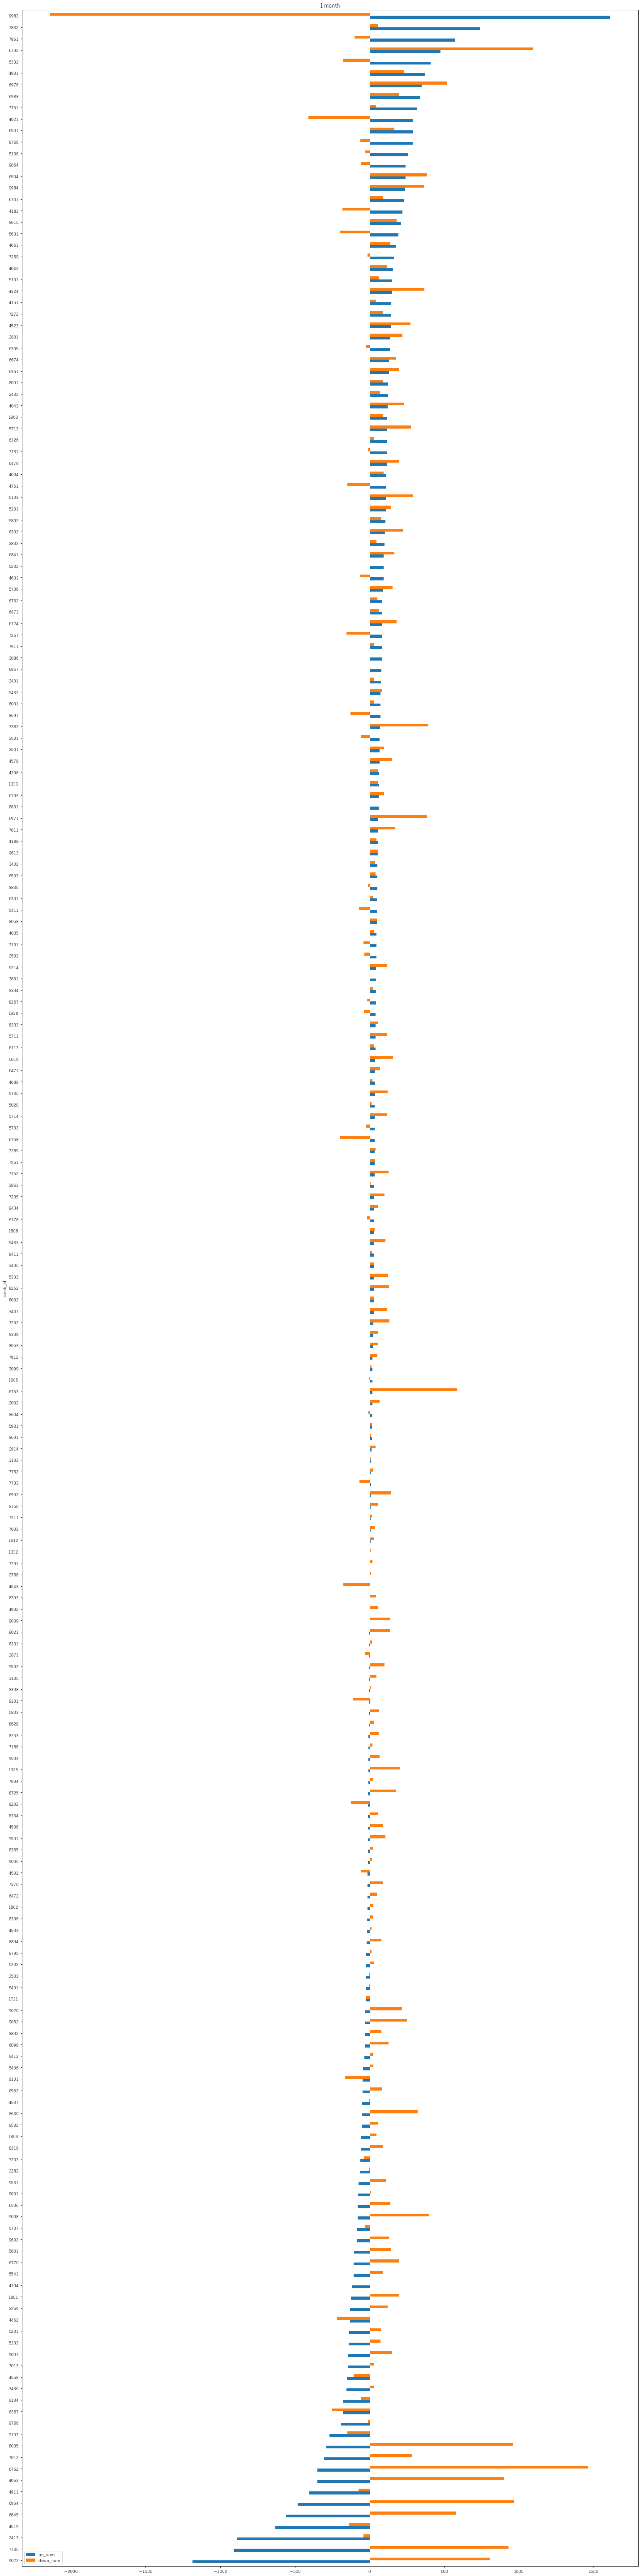

2


<ipython-input-1-bcc1fa388d6f>:302: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


<Figure size 432x288 with 0 Axes>

3


<ipython-input-1-bcc1fa388d6f>:302: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


<Figure size 432x288 with 0 Axes>

In [1]:
"""
TOPIX100 の各銘柄について以下の値を集計し、「寄付きが上向き/下向き」かどうかで銘柄の傾向に違いがあるか確認する
翌日の始値上向き(up)/下向き(down)の陽線(posi)/陰線(nega)の合計値, 平均値, 行数
Usage:
    $ conda activate stock
    $ streamlit run ./app.py
"""
import traceback
import glob
import datetime
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# import seaborn as sns

# 日本語対応 stleamlit share では日本語表記できない...
# font = {"family": "Yu Gothic"}
# matplotlib.rc("font", **font)
plt.rcParams["font.family"] = "Yu Gothic"
# sns.set(font='Yu Gothic')


# stock_dir = "TOPIX100_data"
stock_dir = "../yahoo225_data"
stock_name_csv = "../stock_name_TOPIX100.csv"


def get_stock_df(stock_id):
    csv = stock_dir + "/" + str(stock_id) + ".csv"

    ## TOPIX100_data
    # df = pd.read_csv(
    #    csv,
    #    encoding="SHIFT-JIS",
    #    sep="\t",
    #    parse_dates=["日付"],
    #    na_values=["-"],
    #    dtype="float",
    # )
    # yahoo225_data
    df = pd.read_csv(
        csv,
        encoding="SHIFT-JIS",
        parse_dates=["日付"],
        na_values=["-"],
        dtype="float",
    )

    df["銘柄"] = Path(csv).stem

    df = df.sort_values(by=["日付"])

    df[f"翌日の始値"] = df["始値"].shift(-1)
    df[f"翌日の終値"] = df["終値"].shift(-1)

    # 値の差をそのままつかう場合
    df["翌日の始値-当日の終値"] = df[f"翌日の始値"] - df[f"終値"]
    df["翌日の終値-翌日の始値"] = df[f"翌日の終値"] - df[f"翌日の始値"]
    # 値の差の割合%を取る場合
    # df["翌日の始値-当日の終値"] = ( (df[f"翌日の始値"] - df[f"終値"]) / df[f"終値"] ) * 100
    # df["翌日の終値-翌日の始値"] = ( (df[f"翌日の終値"] - df[f"翌日の始値"]) / df[f"翌日の始値"] ) * 100

    return df


def up_down_summary(stock_id, start_date="2020-01-01", end_date="2020-12-31"):
    df = get_stock_df(stock_id=stock_id)

    df = df[(df["日付"] >= start_date) & (df["日付"] <= end_date)]
    df = df[df["翌日の終値-翌日の始値"].notnull()]  # 欠損ではない行のみ

    # 翌日の 陽線/陰線 の合計
    all_count = df.shape[0]
    all_sum = sum(df["翌日の終値-翌日の始値"])

    # 翌日の始値上向き + 翌日陽線のみ
    df_up_posi = df[(df["翌日の始値-当日の終値"] > 0.0) & (df["翌日の終値-翌日の始値"] > 0.0)]
    up_posi_count = df_up_posi.shape[0]
    up_posi_sum = sum(df_up_posi["翌日の終値-翌日の始値"])

    # 翌日の始値上向き + 翌日陰線のみ
    df_up_nega = df[(df["翌日の始値-当日の終値"] > 0.0) & (df["翌日の終値-翌日の始値"] < 0.0)]
    up_nega_count = df_up_nega.shape[0]
    up_nega_sum = sum(df_up_nega["翌日の終値-翌日の始値"])

    # 翌日の始値下向き + 翌日陽線のみ
    df_down_posi = df[(df["翌日の始値-当日の終値"] < 0.0) & (df["翌日の終値-翌日の始値"] > 0.0)]
    down_posi_count = df_down_posi.shape[0]
    down_posi_sum = sum(df_down_posi["翌日の終値-翌日の始値"])

    # 翌日の始値下向き + 翌日陰線のみ
    df_down_nega = df[(df["翌日の始値-当日の終値"] < 0.0) & (df["翌日の終値-翌日の始値"] < 0.0)]
    down_nega_count = df_down_nega.shape[0]
    down_nega_sum = sum(df_down_nega["翌日の終値-翌日の始値"])

    # 翌日の始値上向きの 陽線/陰線 の合計
    up_sum = up_posi_sum + up_nega_sum

    # 翌日の始値下向きの 陽線/陰線 の合計
    down_sum = down_posi_sum + down_nega_sum

    dict_summary = dict()
    dict_summary["stock_id"] = stock_id
    dict_summary["開始日"] = start_date
    dict_summary["終了日"] = end_date

    dict_summary["開始日の始値"] = int(df.iloc[0]["始値"])
    dict_summary["終了日の始値"] = int(df.iloc[-1]["始値"])
    dict_summary["始値の平均"] = int(df["始値"].mean())

    dict_summary["取引日数"] = all_count  # 行数
    dict_summary["翌日の陽線陰線の合計"] = round(all_sum, 1)  # 翌日の 陽線/陰線 の合計
    dict_summary["翌日の陽線陰線の平均"] = round(all_sum / all_count, 3)  # 翌日の 陽線/陰線 の平均

    # 翌日の始値上向き + 翌日陽線のみ
    dict_summary["up_posi_count"] = up_posi_count  # 行数
    dict_summary["up_posi_sum"] = up_posi_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["up_posi_mean"] = (
        np.nan if up_posi_count == 0 else round(up_posi_sum / up_posi_count, 3)
    )  # 翌日の 陽線/陰線 の平均

    # 翌日の始値上向き + 翌日陰線のみ
    dict_summary["up_nega_count"] = up_nega_count  # 行数
    dict_summary["up_nega_sum"] = up_nega_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["up_nega_mean"] = (
        np.nan if up_nega_count == 0 else round(up_nega_sum / up_nega_count, 3)
    )  # 翌日の 陽線/陰線 の平均

    # 翌日の始値下向き + 翌日陽線のみ
    dict_summary["down_posi_count"] = down_posi_count  # 行数
    dict_summary["down_posi_sum"] = down_posi_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["down_posi_mean"] = (
        np.nan if down_posi_count == 0 else round(down_posi_sum / down_posi_count, 3)
    )  # 翌日の 陽線/陰線 の平均

    # 翌日の始値下向き + 翌日陰線のみ
    dict_summary["down_nega_count"] = down_nega_count  # 行数
    dict_summary["down_nega_sum"] = down_nega_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["down_nega_mean"] = (
        np.nan if down_nega_count == 0 else round(down_nega_sum / down_nega_count, 3)
    )  # 翌日の 陽線/陰線 の平均

    dict_summary["翌日の始値上向き_sum"] = round(up_sum, 1)  # 翌日の始値上向きの 陽線/陰線 の合計
    dict_summary["翌日の始値上向き_mean"] = (
        np.nan
        if up_posi_count + up_nega_count == 0
        else round(up_sum / (up_posi_count + up_nega_count), 3)
    )  # 翌日の始値上向きの 陽線/陰線 の平均

    dict_summary["翌日の始値下向き_sum"] = round(down_sum, 1)  # 翌日の始値下向きの 陽線/陰線 の合計
    dict_summary["翌日の始値下向き_mean"] = (
        np.nan
        if down_posi_count + down_nega_count == 0
        else round(down_sum / (down_posi_count + down_nega_count), 3)
    )  # 翌日の始値下向きの 陽線/陰線 の平均

    dict_summary["翌日陽線の割合"] = round(
        (up_posi_count + down_posi_count) / all_count * 100, 1
    )  # 翌日陽線の割合
    dict_summary["翌日陰線の割合"] = round(
        (up_nega_count + down_nega_count) / all_count * 100, 1
    )  # 翌日陰線の割合

    dict_summary["翌日の始値上向きの割合"] = round(
        (up_posi_count + up_nega_count) / all_count * 100, 1
    )
    dict_summary["翌日の始値下向きの割合"] = round(
        (down_posi_count + down_nega_count) / all_count * 100, 1
    )

    dict_summary["翌日の始値上向きかつ陽線の割合(%)"] = round(up_posi_count / all_count * 100, 1)
    dict_summary["翌日の始値上向きかつ陰線の割合(%)"] = round(up_nega_count / all_count * 100, 1)
    dict_summary["翌日の始値下向きかつ陰線の割合(%)"] = round(down_nega_count / all_count * 100, 1)
    dict_summary["翌日の始値下向きかつ陽線の割合(%)"] = round(down_posi_count / all_count * 100, 1)

    return dict_summary


def plot_sort_type_up_down(_df, sort_type, ascending=True):
    if sort_type == "sum":
        _sort_type = "合計"
    elif sort_type == "mean":
        _sort_type = "平均"
    else:
        _sort_type = sort_type

    # 日本語不可能な場合
    _df = _df.rename(
        columns={
            f"翌日の始値上向き_{sort_type}": f"up_{sort_type}",
            f"翌日の始値下向き_{sort_type}": f"down_{sort_type}",
        }
    )
    _df = _df[[f"stock_id", f"up_{sort_type}", f"down_{sort_type}"]].set_index(
        "stock_id"
    )
    _df = _df.sort_values(by=f"up_{sort_type}", ascending=ascending)

    _df[""]

    # 日本語可能な場合
    # _df = _df.rename(
    #    columns={
    #        f"翌日の始値上向き_{sort_type}": f"翌日の始値上向き_{_sort_type}",
    #        f"翌日の始値下向き_{sort_type}": f"翌日の始値下向き_{_sort_type}",
    #    }
    # )
    # _df = _df[[f"name", f"翌日の始値上向き_{_sort_type}", f"翌日の始値下向き_{_sort_type}"]].set_index("name")
    # _df = _df.sort_values(by=f"翌日の始値上向き_{_sort_type}", ascending=ascending)

    fig = plt.figure(figsize=(10, 10 * (1 + int(_df.shape[0] / 50))))
    ax = fig.add_subplot(1, 1, 1)
    _df.plot.barh(ax=ax)
    ax.set_title(
        f"{sort_type} of positive and negative lines during the period"
    )  # ax.set_title(f"期間中の陽線陰線の{_sort_type}")
    ax.set_xlabel("yen")  # ax.set_xlabel("円")
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    return fig


def get_df_summary(
    start_date, end_date, stock_dir=stock_dir, stock_name_csv=stock_name_csv
):
    stock_ids = [Path(csv).stem for csv in glob.glob(stock_dir + "/*csv")]
    df_summary = None
    for stock_id in stock_ids:
        dict_summary = up_down_summary(
            stock_id=stock_id, start_date=start_date, end_date=end_date
        )
        if df_summary is None:
            df_summary = pd.DataFrame.from_dict(dict_summary, orient="index").T
        else:
            df_summary = df_summary.append(dict_summary, ignore_index=True)

    # 見にくいので 行数の列 は削除
    df_summary = df_summary[
        [
            "stock_id",
            "開始日",
            "終了日",
            "取引日数",
            "開始日の始値",
            "終了日の始値",
            "始値の平均",
            "翌日の陽線陰線の合計",
            "翌日の陽線陰線の平均",
            # "up_posi_sum", "up_nega_sum", "down_posi_sum", "down_nega_sum",
            "翌日の始値上向き_sum",
            "翌日の始値下向き_sum",
            # "up_posi_mean", "up_nega_mean", "down_posi_mean", "down_nega_mean",
            "翌日の始値上向き_mean",
            "翌日の始値下向き_mean",
            # "翌日陽線の割合", "翌日陰線の割合",
            # "翌日の始値上向きの割合", "翌日の始値下向きの割合",
            "翌日の始値上向きかつ陽線の割合(%)",
            "翌日の始値上向きかつ陰線の割合(%)",
            "翌日の始値下向きかつ陰線の割合(%)",
            "翌日の始値下向きかつ陽線の割合(%)",
        ]
    ]

    # 銘柄名つける
    stock_name = pd.read_csv(stock_name_csv, encoding="SHIFT-JIS", dtype="str")
    df_summary = pd.merge(stock_name, df_summary, on="stock_id")

    return df_summary


from datetime import date,timedelta

sort_type = "sum"
year = 2021
if __name__ == "__main__":
    
    max_month = 3 if year == 2021 else 12
    #max_month = 7 if year == 2021 else 12
    
    fig = plt.figure(figsize=(20, 40*2))
    # df_summaries = []
    for m in range(1, max_month+1):
        print(m)
        end_date = date(year,m+1,1) - timedelta(days=1)
        _df = get_df_summary(str(f"2021-{m}-1"), str(end_date))
        # display(df_summary)
        
        _df = _df.rename(
            columns={
                f"翌日の始値上向き_{sort_type}": f"up_{sort_type}",
                f"翌日の始値下向き_{sort_type}": f"down_{sort_type}",
            }
        )
        _df = _df[[f"stock_id", f"up_{sort_type}", f"down_{sort_type}"]].set_index(
            "stock_id"
        )
        _df = _df.sort_values(by=f"up_{sort_type}", ascending=True)

        ax = fig.add_subplot(1, 1, 1)
        ax.set_title(f"{m} month") 
        ax.legend_ = None
        _df.plot.barh(ax=ax)
        # df_summaries.append(_df)

        plt.tight_layout()
        plt.show()